In [1]:
!pip install pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext

# Initialize SparkContext and SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
#Installing necessary packages and set up the environment
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
!tar xf spark-3.3.3-bin-hadoop3.tgz
!pip install -q pyspark findspark

import os

# Set environment variables for Java and Spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

import findspark
findspark.init()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
tar: spark-3.3.3-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [3]:
# Download the dataset
!pip install wget

import wget

link_to_data = 'https://github.com/tulip-lab/sit742/raw/develop/Assessment/2024/data/transactionrecord.gz'
DataSet = wget.download(link_to_data)

#Checking if the file was downloaded correctly and rename it to avoid issues with spaces
print("File downloaded:", os.path.exists(DataSet))

# Renaming file if it contains spaces or special characters
new_file_path = "transactionrecord.gz"
os.rename(DataSet, new_file_path)


File downloaded: True


In [4]:

# Reading the .gz CSV file into a DataFrame using SQLContext
spk_df = sqlContext.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(new_file_path)

In [5]:
spk_df.show(5)  # Printing of the DataFrame

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

In [6]:
#displaying the schema
spk_df.printSchema()

root
 |-- TransactionNo: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- ProductNo: string (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Product_category: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- CustomerNo: integer (nullable = true)
 |-- Country: string (nullable = true)



1.1.1 To count the number of Na  in "Customer NO"

In [7]:
na_count = spk_df.filter(spk_df["CustomerNo"] == "NA").count()
na_count

0

from my solution here i filtred first where customerNo have 'NA' and then use the count() function to count


to change ’NA’ in CustomerNo columns,to’-1’.

In [8]:
spk_df = spk_df.na.replace('NA', '-1', subset=['CustomerNo'])

 From my solution,I firstly counts the occurrences of "NA" in the CustomerNo column, so after this i was able replace them with "-1" using spk_df.na.replace(). I chose this solution because i think filtering is a straightforward way to isolate rows. using this approach made me verify the number of missing values before performing the replacement.

Is actually posibble to  directly use na.fill() to replace null values with "-1".

In terms of Optimality,my solution is effective but not really the most optimal. I think Using na.replace() directly without counting would be faster and be good.

1.1.2 processing the text in ProductName column

In [9]:
from pyspark.sql.functions import regexp_replace, trim


# Removing non-alphabetic characters and keeping  the space
spk_df = spk_df.withColumn("productName_process", regexp_replace('ProductName', "[^a-zA-Z ]", ""))

#removing more than one space with a single space
spk_df = spk_df.withColumn("productName_process", regexp_replace('productName_process', " +", " "))

# Trimming unnecessary spaces at the end or start
spk_df = spk_df.withColumn("productName_process", trim("productName_process"))

#displaying 5 rows
spk_df.select("ProductName", "productName_process").show(5, truncate=False)



+-----------------------------------+-----------------------------------+
|ProductName                        |productName_process                |
+-----------------------------------+-----------------------------------+
|Set Of 2 Wooden Market Crates      |Set Of Wooden Market Crates        |
|Christmas Star Wish List Chalkboard|Christmas Star Wish List Chalkboard|
|Storage Tin Vintage Leaf           |Storage Tin Vintage Leaf           |
|Tree T-Light Holder Willie Winkie  |Tree TLight Holder Willie Winkie   |
|Set Of 4 Knick Knack Tins Poppies  |Set Of Knick Knack Tins Poppies    |
+-----------------------------------+-----------------------------------+
only showing top 5 rows



 For my solution i made use of regexp_replace to remove non-alphabetic characters, i was able to also use it to keep spaces and also trim to clean up. I made use of this approach because i found it very easy to be used to process the ProductName column by ensuring only alphabetic characters remain.

I can also make use of Python's withColumn() and with a custom function for this same result, but i think is time consuming.

I can say is optimal because regexp_replace and trim are efficient built-in Spark functions that are used for large datasets,to achieve things faster.

 Q1.2.1 To calculate the revenue


In [10]:

# Calculating the revenue for each transaction
spk_df = spk_df.withColumn("Revenue", (spk_df['price'] * spk_df['quantity']).cast("float"))

spk_df.show(5)


+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|Revenue|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|Set Of Wooden Mar...| 257.64|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|Christmas Star Wi...|  383.4|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|Storage Tin Vinta...| 138.36|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|Tree TLight Holde...| 

getting my result I calculated the Revenue by multiplying the price and quantity columns and using the cast() to convert the result to float format. I used it because is the easiest way to computes the revenue for each transaction.

the alternative method is by using withColumn() with a custom function, but that would might be less efficient for large datasets.

yes this solution is optimal because I make  use of Spark's built-in operations, which are highly good data processing, making it fast and scalable.

Q1.2.2 Transform the pyspark dataframe to pandas dataframe

In [11]:
import pandas as pd
#transforming spk_df to pandas
df = spk_df.toPandas()

#converting the date column to a datetype
df['transaction_date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

df.head()


,TransactionNo,Date,ProductNo,ProductName,Product_category,Price,Quantity,CustomerNo,Country,productName_process,Revenue,transaction_date
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,0ca,21.47,12,17490,United Kingdom,Set Of Wooden Market Crates,257.640015,2019-12-09
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,0ca,10.65,36,13069,United Kingdom,Christmas Star Wish List Chalkboard,383.399994,2019-12-09
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,0ca,11.53,12,13069,United Kingdom,Storage Tin Vintage Leaf,138.360001,2019-12-09
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,0ca,10.65,12,13069,United Kingdom,Tree TLight Holder Willie Winkie,127.800003,2019-12-09
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,0ca,11.94,6,13069,United Kingdom,Set Of Knick Knack Tins Poppies,71.639999,2019-12-09


For this solution, I converted the Spark DataFrame to a Pandas DataFrame using toPandas() and i also formats the date column to a proper datetime format using pd.to_datetime. I chose this solution because this is the best and easier way for it to be converted.

I can actually convert it in pyspark  using to_date() before transforming it to pandas, but Pandas provides simpler syntax for this kind of transformation.

yes, my solution is optimal is godd for situation like this (transitioning from Spark operations to local Pandas operations). It's optimal for smaller because is efficient and easier to use.

1.2.3

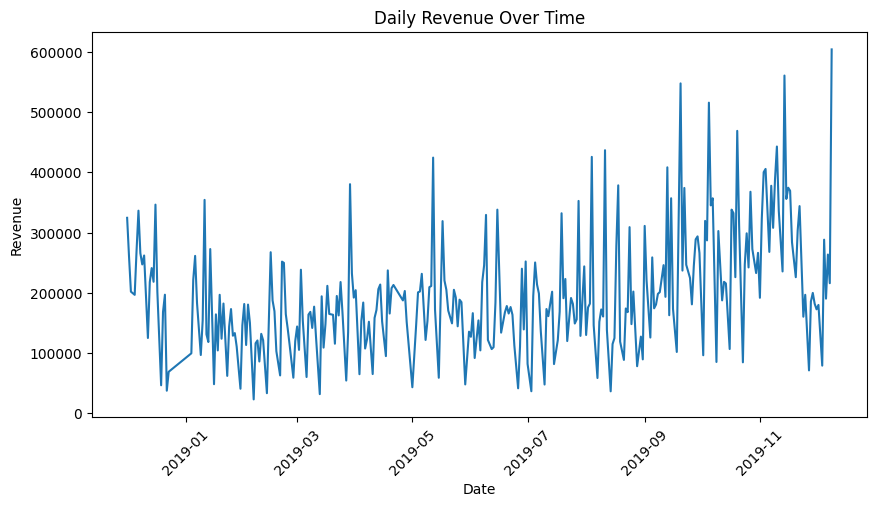

In [12]:
import matplotlib.pyplot as plt

daily_rev = df['Revenue'].groupby(df['transaction_date']).sum().reset_index()

plt.figure(figsize=(10,5))
plt.plot(daily_rev['transaction_date'], daily_rev['Revenue'])
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Daily Revenue Over Time')
plt.xticks(rotation=45)
plt.show()

 For this solution i group the revenue by transaction_date, sums it, and plots by using matplotlib to visualize daily revenue trends. I chose this method because I am more familiar to this method and is also effective for identifying patterns in time series data.

I  could have use other method of built-in plotting libraries like Seaborn for enhanced visuals, but i believe matplotlib is easy-to-use for me.

In terms of optimality the solution is optimal for simplicity and flexibility. because matplotlib provides direct control over plots, .

Over the year, the revenue appears to increase. And the increament spikes towards the ending of the year, around September and November are higher than those seen earlier in the year. This trend may indicate a growth in sales volume over time due to holidays and end of the year sale or the impact of cumulative marketing efforts.

Low-Revenue Periods:
There are notable periods where revenue dips to relatively low levels, suggesting times of reduced sales activity. These dips could be due to factors like reduced consumer spending, or  promotional activities, or some external factors affecting business operations.

1.3.1

<ipython-input-13-eb9e51abcc71>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_day_rev = df.groupby('day_of_week')['Revenue'].mean().reset_index()


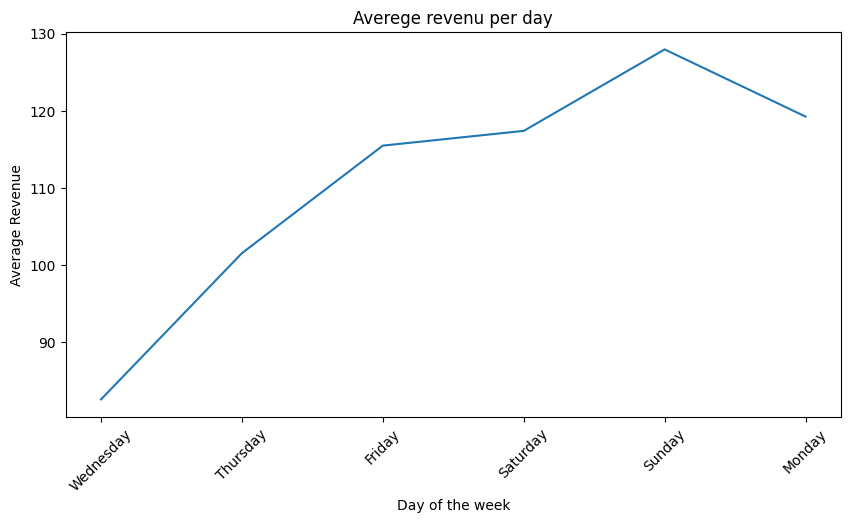

In [13]:
#to create day of the week column
df['day_of_week'] = df['transaction_date'].dt.day_name()

day_order = [ 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','Monday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

#to calculate the average revenue for each day of the week
avg_day_rev = df.groupby('day_of_week')['Revenue'].mean().reset_index()


#plotting
plt.figure(figsize=(10,5))
plt.plot(avg_day_rev['day_of_week'], avg_day_rev['Revenue'])
plt.xlabel('Day of the week')
plt.ylabel('Average Revenue')
plt.title('Averege revenu per day')
plt.xticks(rotation=45)
plt.show()

Sunday Leads in Revenue: The graph clearly indicates that Sunday generates the most sales on average compared to other days of the week. This pattern suggests that Sunday might be a particularly busy day for the business, due to higher customers, weekend shopping e.t.c

from my solution I calculated the average revenue for each day of the week and plots it. to make the days to be in order I ordered using pd.Categorical() to ensure correct weekday order, Then i plotted a line plot using matplotlib to visualize the trends. I chose this method because it provides a clear and efficient solution and im more confident using matplotlib for visualization

I can also use Seaborn’s lineplot(). this could simplify plotting. .

Yes my solution is optimal because of its simplicity, flexibility, and also easy for me to be able  customize.

1.3.2

In [14]:
#filtering data for sunday
sunday_df = df[df['day_of_week']=='Sunday']


#grouping by productname_process and calculating total sales and revenue
product_sv = sunday_df.groupby('productName_process').agg(
    tota_sales = ('Quantity', 'sum'),
    total_revenue = ('Revenue', 'sum')
).reset_index()

highest_revenue_product = product_sv.sort_values(by='total_revenue', ascending=False).head(1)
#highest_revenue_product

highest_sales_volume_product = product_sv.sort_values(by='tota_sales', ascending=False).head(1)
#highest_sales_volume_product

print("Product with the highest revenue on Sunday:")
print(highest_revenue_product)

print("\nProduct with the highest sales volume (quantity) on Sunday:")
print(highest_sales_volume_product)

Product with the highest revenue on Sunday:
                  productName_process  tota_sales  total_revenue
3286  World War Gliders Asstd Designs       18051   187081.34375

Product with the highest sales volume (quantity) on Sunday:
                  productName_process  tota_sales  total_revenue
3286  World War Gliders Asstd Designs       18051   187081.34375


getting my solution i firstly filters the data for Sunday, gotten from my previous analysis as the day with the highest revenue. I then grouped the data by productName_process (each product) and calculates the

Total revenue:I used sum() on the Revenue column to identify the product to get the highest revenue.
Total sales volume: I used sum() on the Quantity column to find the product with the highest quantity sold. and I finally sorts the results to find the top product by revenue and sales volume. I chose this method because it provides a clear and efficient solution for my analysis and im more confident with it

Another method i could have used is to calculate the with seperate quaries

In terms of optimality the solution is optimal because i was able to groupby() and agg() to handle the data easily

Q1.3.3

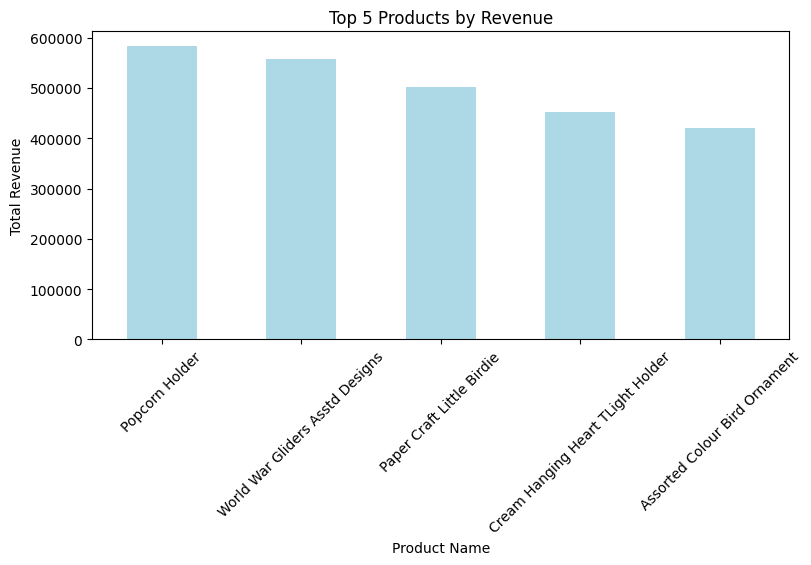

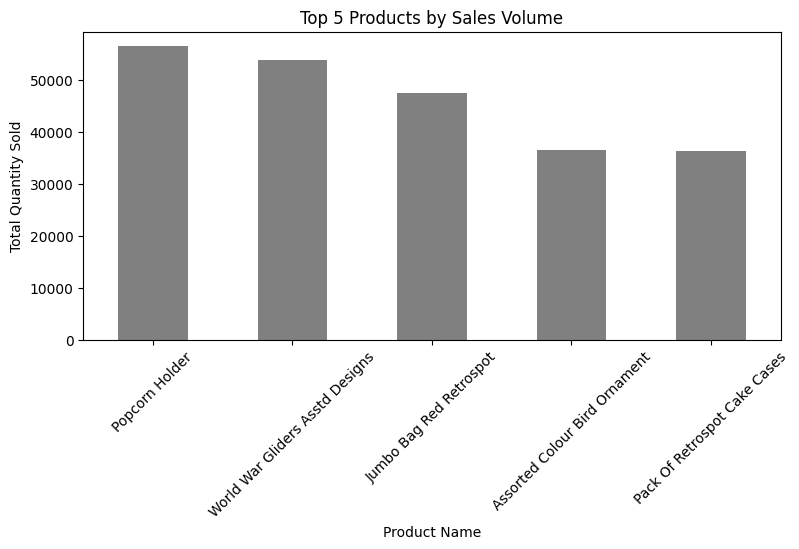

In [15]:
# Top 5 products by revenue in general
top5_products_revenue = df.groupby('productName_process')['Revenue'].sum().nlargest(5)

# Top 5 products by sales volume in general
top5_products_volume = df.groupby('productName_process')['Quantity'].sum().nlargest(5)

# Plotting top 5 products by revenue
plt.figure(figsize=(9,4))
top5_products_revenue.plot(kind='bar', color='lightblue')
plt.xlabel('Product Name')
plt.title('Top 5 Products by Revenue')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

# Plotting top 5 products by sales volume
plt.figure(figsize=(9,4))
top5_products_volume.plot(kind='bar', color='grey')
plt.xlabel('Product Name')
plt.title('Top 5 Products by Sales Volume')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.show()


In terms of revenue from the graph
the top 5 products that made the most money. "Popcorn Holder" brought in the highest revenue, followed by "World War Gliders Assorted Designs" and "Paper Craft Little Birdie". While all five products earned a lot, "Popcorn Holder" stands out as the biggest earner.

In terms of highest sales
the top 5 products that were sold in the highest quantities. are "Popcorn Holder" sold the most, followed closely by "World War Gliders Assorted Designs" and "Jumbo Bag Red Retrospot". The other two products, "Assorted Colour Bird Ornament" and "Pack Of Retrospot Cake Cases", also had high sales, but not as much as the top three.


FRom my solution I grouped the data by productName_process to get the total revenue and total sales volume, and I then used nlargest(5) to select the top 5 products from each category. then i created a Bar plots using matplotlib to visualize the top products by both revenue and sales. I chose this method because it provides a clear and efficient and im more confident using matplotlib

 Seaborn's barplot() can also be use for better visualisation.

Yes the solution is optimal small-to-medium range of dataset, and It also balances simplicity.

1.4

In [16]:
#grouping the data by country and calculate the total revenue
country_rev = df.groupby('Country')['Revenue'].sum().reset_index()

#to get the with highest revenue
highest_rev_country = country_rev.loc[country_rev['Revenue'].idxmax()]

#displaying the country
print(f"highest revenue country is {highest_rev_country['Country']} with total revenue of {highest_rev_country['Revenue']}")

highest revenue country is United Kingdom with total revenue of 49994032.0



From my solution, I grouped the data by country and went ahead to calculates the total revenue per country using the groupby() function. After that, I finds the country with the highest revenue using idxmax(). I chose this method because using this approach ensures that the country with the maximum revenue was identified efficiently.

In terms of other solution:
I can actually use sorting by Revenue and select the top entry, but i think using idxmax() is more direct and efficient for this kind of task.

In terms Optimality:
My solution is optimal because of its simplicity and being efficient. It uses Pandas operations for grouping and indexing, making it scalable for larger datasets.

To get the month in united kingdom that has the highest total revenue

In [17]:
#filtering the data for uk
uk_df = df[df['Country'] == 'United Kingdom'].copy()

uk_df['Month'] = uk_df['transaction_date'].dt.month_name()

#grouping by month and calculate the total revenue
monthly_revenue = uk_df.groupby('Month')['Revenue'].sum().reset_index()

#to get the month with the highest revenue
highest_month_rev = monthly_revenue.loc[monthly_revenue['Revenue'].idxmax()]

#displaying the output
print(f"The month with the highest revenue is {highest_month_rev['Month']} with a total revenue of {highest_month_rev['Revenue']}.")

The month with the highest revenue is November with a total revenue of 6737640.0.



For my solution, I filters the data for the UK, and then I created a Month column from the transaction_date column, and  then grouped the data by Month to calculate total revenue. Finally,I used idxmax() to get the month with the highest revenue. I chose this method because it provides a clear and efficient solution


Other solution that could be use to achieve this is pivot_table(). pivot_table() can be use to organize monthly revenue or sort the grouped data, but using idxmax() is faster and more efficient.


In terms of optimality the solution is optimal due to its simplicity, efficiency, and the clear use of Pandas functions. Besides this approach ensures clarity in determining peak revenue months.

1.5

In [18]:
#filtering out transactions that are not for shopping
valid_df = df[df['Quantity']> 0].copy()

#to calculate the distinct count of transactionNo on customer level
unique_tran = valid_df.groupby('CustomerNo')['TransactionNo'].nunique().reset_index()

#getting the customer with the most highest count of transactions
highest_patronage_cust = unique_tran.loc[unique_tran['TransactionNo'].idxmax()]

print(f"The customer with the highest patronage is {highest_patronage_cust['CustomerNo']} with {highest_patronage_cust['TransactionNo']} transactions.")

#filtering the data for customer with highest patronage
highest_patronage_cust_df = valid_df[valid_df['CustomerNo'] == highest_patronage_cust['CustomerNo']]

#getting the product the customer is spending on the most
most_spending_prod = highest_patronage_cust_df.groupby('productName_process')['Quantity'].sum().reset_index()

#the product with the highest purchase by the customer
most_spending_prod = most_spending_prod.loc[most_spending_prod['Quantity'].idxmax()]
#displaying the output
print(f"The product the customer is spending the most on is {most_spending_prod['productName_process']} with a total quantity of {most_spending_prod['Quantity']} units.")

The customer with the highest patronage is 12748 with 207 transactions.
The product the customer is spending the most on is Victorian Metal Postcard Spring with a total quantity of 595 units.



For my solution I filtered the code to get the valid transactions with Quantity > 0, then I grouped the data by CustomerNo to find the customer with the highest distinct count of transactions, and then identifies which product the customer buys most frequently based on the total quantity. I chose this method because it provides a clear and efficient solution to determine customer shopping behavior.


In terms of the other solution, is by defining a function to filter, calculate the transaction and identify the customer and finally find the most purchased product.

In terms of optimality i believe this solution is optimal because of its simplicity and use of groupby() and nunique() functions for quick analysis.

1.6.1

In [19]:
import pandas as pd

#Filtering the dataFrame to only include positive quantities
df_filtered = df[df['Quantity'] > 0]

#Grouping by 'transactionNo' and then aggregate 'product_category' and 'productName_process' into lists
df_grouped = df_filtered.groupby('TransactionNo').agg({
    'Product_category': lambda x: list(x),
    'productName_process': lambda x: list(x)
}).reset_index()

# display the top 10
df_grouped.head(10)


,TransactionNo,Product_category,productName_process
0,536365,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca]","[Cream Hanging Heart TLight Holder, White Moro..."
1,536366,"[0ca, 0ca]","[Hand Warmer Union Jack, Hand Warmer Red Retro..."
2,536367,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...","[Assorted Colour Bird Ornament, Poppys Playhou..."
3,536368,"[0ca, 0ca, 0ca, 0ca]","[Jam Making Set With Jars, Red Coat Rack Paris..."
4,536369,[0ca],[Bath Building Block Word]
5,536370,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...","[Alarm Clock Bakelike Pink, Alarm Clock Bakeli..."
6,536371,[0ca],[Paper Chain Kit S Christmas]
7,536372,"[0ca, 0ca]","[Hand Warmer Red Retrospot, Hand Warmer Union ..."
8,536373,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...","[Cream Hanging Heart TLight Holder, White Moro..."
9,536374,[0ca],[Victorian Sewing Box Large]


For this solution I aggregates both product_category and productName_process into lists grouped by TransactionNo. I chose this method beacuase grouping allows us to capture all products and their categories purchased in each transaction, providing a clear view of the shopping for each transaction.

 Another approach I could have gone for is to use groupby with the apply function, which would actually give similar results but is less concise. asides that, pivot tables could  also be used.

In terms of optimality, Yes, this solution is optimal because it easily aggregates data using groupby and lambda functions, making it flexible and scalable.

1.6.2

In [20]:
# Function to remove adjacent duplicates from a list
def remove_duplicate(lst):
    return [v for i, v in enumerate(lst) if i == 0 or v != lst[i-1]]

# Applying the function to remove duplicates in product_category
df_grouped['Product_category'] = df_grouped['Product_category'].apply(remove_duplicate)

# Saving the processed DF as 'df_1'
df_1 = df_grouped.copy()

# displaying top 10 rows of the processed DataFrame
df_1.head(10)


,TransactionNo,Product_category,productName_process
0,536365,[0ca],"[Cream Hanging Heart TLight Holder, White Moro..."
1,536366,[0ca],"[Hand Warmer Union Jack, Hand Warmer Red Retro..."
2,536367,[0ca],"[Assorted Colour Bird Ornament, Poppys Playhou..."
3,536368,[0ca],"[Jam Making Set With Jars, Red Coat Rack Paris..."
4,536369,[0ca],[Bath Building Block Word]
5,536370,[0ca],"[Alarm Clock Bakelike Pink, Alarm Clock Bakeli..."
6,536371,[0ca],[Paper Chain Kit S Christmas]
7,536372,[0ca],"[Hand Warmer Red Retrospot, Hand Warmer Union ..."
8,536373,[0ca],"[Cream Hanging Heart TLight Holder, White Moro..."
9,536374,[0ca],[Victorian Sewing Box Large]


For my solution, this aproach was selected based on the fact that task requires removing adjacent duplicates in lists within the Product_category so therefore i believe defining a fuction is one of the easiest way to go about it column. The remove_duplicates function is applied to each list, ensuring that adjacent identical elements are removed.

 Another aproach could have been to iterate through each list  using a for loop, or using pandas methods with shift() and diff() on categorical data.

In terms of optimality, Yes, this solution is optimal as it uses list comprehension, which is very efficient and concise in Python.

1.7.1

In [21]:
#Creating a new column prod_len for the length of the list in product_category
df_1['prod_len'] = df_1['Product_category'].apply(len)

#displaying the first five rows of the dataframe df_1
df_1.head(5)


,TransactionNo,Product_category,productName_process,prod_len
0,536365,[0ca],"[Cream Hanging Heart TLight Holder, White Moro...",1
1,536366,[0ca],"[Hand Warmer Union Jack, Hand Warmer Red Retro...",1
2,536367,[0ca],"[Assorted Colour Bird Ornament, Poppys Playhou...",1
3,536368,[0ca],"[Jam Making Set With Jars, Red Coat Rack Paris...",1
4,536369,[0ca],[Bath Building Block Word],1


 For my solution apply(len) was use to compute the length of each list in the Product_category column. I chose this approach beacuse it easily solves the task of calculating the number of product categories in each transaction. .

In terms of other solution I could also use an approach with loops to count the list lengths, but apply(len) is more straightforward.

In terms of optimality Yes, this it is optimal because apply(len) is a built-in pandas function that efficiently computes the desired results for each row.

1.72

In [22]:
#declaring my data_processing function
def data_processing(df, maxlength=5, minlength=2):
    #putting start and conversion to the product_category list and join elements with  >
    df['path'] = df['Product_category'].apply(lambda x: 'start > ' + ' > '.join(x) + ' > conversion')

    #filtering df based on prod_len
    df_filtered = df[(df['prod_len'] <= maxlength) & (df['prod_len'] >= minlength)]

    # return the filtered df
    return df_filtered

#applying the function to the df with maxlength=5 and minlength=2
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# displaying the new dataframe 'df_2'
df_2.head()



,TransactionNo,Product_category,productName_process,prod_len,path
13,536378,"[0ca, 1ca, 0ca]","[Strawberry Charlotte Bag, Childrens Cutlery R...",3,start > 0ca > 1ca > 0ca > conversion
27,536395,"[0ca, 1ca, 0ca]","[Black Heart Card Holder, Assorted Colour Bird...",3,start > 0ca > 1ca > 0ca > conversion
36,536404,"[0ca, 1ca, 0ca, 4ca, 0ca]","[Heart Ivory Trellis Small, Clear Drawer Knob ...",5,start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion
40,536408,"[0ca, 1ca, 0ca]","[Magic Drawing Slate Dinosaur, Magic Drawing S...",3,start > 0ca > 1ca > 0ca > conversion
42,536412,"[0ca, 4ca, 0ca]","[Round Snack Boxes Set Of Woodland, Round Snac...",3,start > 0ca > 4ca > 0ca > conversion


For my solution, the function data_processing that was defined  transforms each list in Product_category by appending "start" at the beginning and "conversion" at the end. It uses apply() with a lambda function to concatenate the product categories with " > " as the separator.I chose this aproach because of the usage of pandas vectorized for list that make it easy to understand and work well with large dataset.

I could have make use loops to join elements, but apply with a lambda function is much cleaner and more easy.

In terms of optimalty, Yes, my solution is optimal because it male use of apply() for concise list transformation and It is fast for large datasets.

1.81

In [23]:
#to get the count pattern in column path
#setting my list pf pattern

patterns = [' > 0ca > conversion', ' > 1ca > conversion',
            ' > 2ca > conversion', ' > 3ca > conversion', ' > 4ca > conversion']

#defining a dic to store the result
patt_counts = {}

# Looping over each pattern and count in the path column
for pattern in patterns:
    pattern_count = df_2['path'].str.endswith(pattern).sum()
    patt_counts[pattern] = pattern_count

# getting the results
for pattern, count in patt_counts.items():
    print(f"The count of transactions ending with: '{pattern}' is {count}")

The count of transactions ending with: ' > 0ca > conversion' is 3056
The count of transactions ending with: ' > 1ca > conversion' is 26
The count of transactions ending with: ' > 2ca > conversion' is 144
The count of transactions ending with: ' > 3ca > conversion' is 68
The count of transactions ending with: ' > 4ca > conversion' is 198



using a list of patterns and looping over them to count how many transactions in the path column end with each pattern using str.endswith() is the best
because the approach easily finds matching patterns without manually filtering each pattern one by one.


Another method that be could be used is using regular expressions (regex) but str.endswith() is faster and easier to apply for this specific case of ending patterns.

In terms of optimality ,Yes, my solution is optimal for pattern matching as it uses vectorized string operations, making it good for large datasets.

1.8.2

In [24]:
#setting a list of patterns
patterns = ['0ca > 0ca', '0ca > 1ca', '0ca > 2ca', '0ca > 3ca', '0ca > 4ca', '0ca > conversion']

# Dictionary to store the count
pattern_counts = {}

# Looping over each pattern and count within each transaction
for pattern in patterns:
    # str.count() to be used
    pattern_count = df_2['path'].str.count(pattern).sum()
    pattern_counts[pattern] = pattern_count

# get the results for each pattern
for pattern, count in pattern_counts.items():
    print(f"The '{pattern}' total count is {count}.")


The '0ca > 0ca' total count is 0.
The '0ca > 1ca' total count is 1222.
The '0ca > 2ca' total count is 1137.
The '0ca > 3ca' total count is 343.
The '0ca > 4ca' total count is 1198.
The '0ca > conversion' total count is 3056.



For my solution, the code loops over each pattern and uses str.count() to count occurrences of each pattern within the path column of df_2, including multiple occurrences within the same transaction. I chose this method because it make sure that all patterns are counted, even if they appear more than once in a single transaction.

Other methos that could have been used is Regular expressions (regex) to find more complex patterns, but str.count() is simpler and efficient for this scenerio.

In terms of optimality, yes, my solution is optimal as it leverages Pandas' str.count() to handle multiple pattern occurrences efficiently.

1.83

In [25]:
#define the pattern
pattern = '> 0ca >'

##to get the count
pattern_count = df_2['path'].str.count(pattern).sum()

#dispaly the result
print(f"The count of transactions containing '{pattern}' is {pattern_count}.")


The count of transactions containing '> 0ca >' is 6956.



For my solution, I used the str.count() function to count how many times the pattern '> 0ca >' appears in the path column. I chose this aproach beacause is a straightforward and efficient way to count the specified pattern across all transactions.

Other approach that is usable is Regular expressions (regex) for more complex matching, but since the task wants to count exact string patterns, str.count() is the simplest method to use.

In terms of optimality yes, this solution is optimal for counting string patterns. It uses str.count(), which is fast and easy for processing large datasets.

1.8.4

In [26]:
#putting the pattern and their count from answer 1.8.2 in a dictionary
pattern_counts = {
    '0ca > 0ca': 0,
    '0ca > 1ca': 1222,
    '0ca > 2ca': 1137,
    '0ca > 3ca': 343,
    '0ca > 4ca': 1198,
    '0ca > conversion': 3056
}

# the answer from 1.8.3
pattern_0ca = 6956

# Initialize a variable
final_sum = 0

# Looping over each pattern result in pattern_counts and divide by pattern_0ca
for pattern, count in pattern_counts.items():
    final_sum += count / pattern_0ca

# Print result
print(f"The final value is: {final_sum}")


The final value is: 1.0



From my solution I store the results from 1.8.2 in a dictionary and divides each count by the result from 1.8.3 (pattern_0ca). I then sum the results, achieving . I used this approach beacause the computation is in a straightforward way and it allows for easy manipulation of results.

I can also use Pandas to store the values and perform vectorized operations. but manually iterating through the dictionary is easy.

In terms of optimality, yes, this solution is optimal especially for not too big data, because It efficiently computes the required sum and division using basic Python operations.

1.9.1

In [27]:

#Filtering out the transactions with negative quantity values
positive_df = df[df['Quantity'] > 0]

#getting the top 100 products by the sum of quantity
top_100 = positive_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index

#filtering to keep only the top 100 products
df_top_products = positive_df[positive_df['productName_process'].isin(top_100)]

#Building the transaction level DataFrame
transaction_df = df_top_products.pivot_table(
    index='TransactionNo',
    columns='productName_process',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Displaying the transaction-level DataFrame
transaction_df.head(10)


productName_process,Aged Glass Silver TLight Holder,Antique Silver TLight Glass,Assorted Colour Bird Ornament,Assorted Colours Silk Fan,Assorted Flower Colour Leis,Asstd Design d Paper Stickers,Bag g Swirly Marbles,Black Record Cover Frame,Brocade Ring Purse,Bubblegum Ring Assorted,...,Strawberry Charlotte Bag,Sweetheart Fairy Cake Cases,Teatime Fairy Cake Cases,Travel Card Wallet Keep Calm,Victorian Glass Hanging TLight,Vintage Snap Cards,Wooden Heart Christmas Scandinavian,Wooden Star Christmas Scandinavian,Woodland Charlotte Bag,World War Gliders Asstd Designs
TransactionNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536378,0,0,0,0,0,0,0,0,0,0,...,10,0,24,0,0,0,0,0,0,0
536380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



I Picked this approach because is the easiest way and more efficient way for this task. As I first filter out transactions with negative quantities and then selects the top 100 products by total quantity sold. Then using pivot_table(), to transforms the data to create a transaction-level dataFrame where each row represents a transaction, and each product becomes a column. on.

Another usable apraoch is by using groupby() and unstack(), but pivot_table() is more easier for this task.

In terms of optimality yes, my solution is optimal because pivot_table() is designed to handle such transformations efficiently.

1.9.2

In [28]:
!pip install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Filtering transactions with 4 or more unique items
transaction_df['Total_Items'] = transaction_df.gt(0).sum(axis=1)
filtered_4 = transaction_df[transaction_df['Total_Items'] >= 4].drop(columns='Total_Items')

#Converting quantities to binary (any quantity greater than 0 is considered 1, otherwise 0)
binary_tran = filtered_4.applymap(lambda x: 1 if x > 0 else 0)

# Running the Apriori algorithm with minimum support of 1.5%
_itemsets = apriori(binary_tran, min_support=0.015, use_colnames=True)

# Running the association rules based on support
rules = association_rules(_itemsets, metric="support", min_threshold=0.015)

# Displaying the _itemsets
print("itemsets:")
_itemsets.head()


<ipython-input-28-cc967fa59170>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_tran = filtered_4.applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


itemsets:


,support,itemsets
0,0.031276,(Aged Glass Silver TLight Holder)
1,0.085835,(Antique Silver TLight Glass)
2,0.126928,(Assorted Colour Bird Ornament)
3,0.054698,(Assorted Colours Silk Fan)
4,0.057083,(Bag g Swirly Marbles)




This output is showing groups of products that are often bought together by customers, along with how frequently they are purchased together, which is shown by the support value. For example, in the second row, Antique Silver TLight Glass is bought in about 8.6% of transactions, while Assorted Colour Bird Ornament is bought in 12.7% of transactions. The lower part of the table shows the rate at which combinations like different types of Lunch Bags that are also frequently bought together.

Stores can use this information to know which products customers tend to buy together, which can help with product placement, promotions, or creating special offers that encourage customers to buy related products.

In [29]:
print("\nAssociation Rules:")
rules.head()


Association Rules:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Assorted Colour Bird Ornament),(Antique Silver TLight Glass),0.126928,0.085835,0.021178,0.166851,1.943867,0.010283,1.097241,0.556153
1,(Antique Silver TLight Glass),(Assorted Colour Bird Ornament),0.085835,0.126928,0.021178,0.246732,1.943867,0.010283,1.159045,0.531153
2,(Assorted Colours Silk Fan),(Antique Silver TLight Glass),0.054698,0.085835,0.016830,0.307692,3.584716,0.012135,1.320461,0.762760
3,(Antique Silver TLight Glass),(Assorted Colours Silk Fan),0.085835,0.054698,0.016830,0.196078,3.584716,0.012135,1.175863,0.788739
4,(Antique Silver TLight Glass),(Charlotte Bag Pink Polkadot),0.085835,0.098177,0.016269,0.189542,1.930626,0.007842,1.112734,0.527293


from the my solution, I filtered transactions with 4 or more unique items, Iconverted the quantities into binary, and runs the Apriori algorithm to identify frequent itemsets with a minimum support of 1.5%. I chose this approach  because of it's efficiency because it focuses on relevant transactions and generates meaningful rules.

Another solution is to use FP-Growth , as it is faster for larger datasets and does not require candidate generation.

In terms of optimalty yes, it  Apriori is optimal, especially with the 1.5% support threshold to reduce insignificant itemsets.

1.93

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Running the Apriori algorithm with minimum support of 1.0%
frequent = apriori(binary_tran, min_support=0.01, use_colnames=True)

#getting the association rules
rules = association_rules(frequent, metric="lift", min_threshold=10)

#Filtering the rules with lift > 10
filtered_rules = rules[rules['lift'] > 10]

# Display the filtered rules
filtered_rules


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Wooden Heart Christmas Scandinavian),(Wooden Star Christmas Scandinavian),0.054979,0.053296,0.042637,0.775510,14.551020,0.039707,4.217136,0.985456
1,(Wooden Star Christmas Scandinavian),(Wooden Heart Christmas Scandinavian),0.053296,0.054979,0.042637,0.800000,14.551020,0.039707,4.725105,0.983704
2,"(Antique Silver TLight Glass, Wooden Heart Chr...",(Wooden Star Christmas Scandinavian),0.012202,0.053296,0.010519,0.862069,16.175136,0.009869,6.863604,0.949766
3,"(Antique Silver TLight Glass, Wooden Star Chri...",(Wooden Heart Christmas Scandinavian),0.012903,0.054979,0.010519,0.815217,14.827806,0.009810,5.114231,0.944749
4,(Wooden Heart Christmas Scandinavian),"(Antique Silver TLight Glass, Wooden Star Chri...",0.054979,0.012903,0.010519,0.191327,14.827806,0.009810,1.220637,0.986813
...,...,...,...,...,...,...,...,...,...,...
53095,"(Strawberry Charlotte Bag, Charlotte Bag Suki ...","(Woodland Charlotte Bag, Red Retrospot Charlot...",0.057363,0.011781,0.010519,0.183374,15.564967,0.009843,1.210124,0.992698
53096,"(Strawberry Charlotte Bag, Charlotte Bag Pink ...","(Woodland Charlotte Bag, Red Retrospot Charlot...",0.052314,0.012062,0.010519,0.201072,16.670304,0.009888,1.236580,0.991904
53097,"(Charlotte Bag Suki Design, Regency Cakestand ...","(Woodland Charlotte Bag, Red Retrospot Charlot...",0.032819,0.012763,0.010519,0.320513,25.112708,0.010100,1.452915,0.992761
53098,"(Regency Cakestand Tier, Charlotte Bag Pink Po...","(Woodland Charlotte Bag, Red Retrospot Charlot...",0.030014,0.012623,0.010519,0.350467,27.764798,0.010140,1.520135,0.993811


The outputshows how  products are often bought together by customers. The items on the left (antecedents) are products that, when purchased, lead to the purchase of the items on the right (consequents). For example, if a customer buys a Wooden Heart Christmas decoration, there is a good chance they will also buy a Wooden Star Christmas decoration.

The numbers in the table help us understand this relationship:

In terms of Support. It shows how often the two items are bought together. For instance, in the first row, the Wooden Heart and Wooden Star are bought together in about 4.26% of transactions.
Confidence is how likely the second product (the consequent) is purchased when the first product (the antecedent) is bought. In the second row, 77.55% of the time when someone buys a Wooden Heart, they also buy a Wooden Star.
Lift tells us how much more likely customers are to buy the second item (consequent) when they already have the first item (antecedent), compared to buying it by chance. In terms of lift. A lift of 14.55 means customers are more than 14 times more likely to buy the Wooden Star if they already have the Wooden Heart in their basket.


 This method is mostly used for market basket analysis and efficiently discovers frequent itemsets and association rules in transactional data.


FP-Growth,can also be used which is faster for larger datasets. Additionally, i can also adjust the threshold metrics like confidence or leverage.

In terms of optimality, yes, using Apriori with the given support and lift thresholds is optimal for identifying meaningful item associations.

1.9.4

trying to explore different thresholds combination of support , confidence, and lift

#### High Support (≥ 2%) and High Confidence (≥ 75%)

In [31]:

# Running the Apriori algorithm with minimum support of 2% (0.02)
freq = apriori(binary_tran, min_support=0.02, use_colnames=True)

#getting the association rules with minimum confidence of 75%
rules_high_conf = association_rules(freq, metric="confidence", min_threshold=0.75)

#saving and display the top 5 results
rules_high_conf.to_csv('rules_high_confidence.csv', index=False)
print("High Support and High Confidence Rules:")
rules_high_conf.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


High Support and High Confidence Rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Wooden Heart Christmas Scandinavian),(Wooden Star Christmas Scandinavian),0.054979,0.053296,0.042637,0.775510,14.551020,0.039707,4.217136,0.985456
1,(Wooden Star Christmas Scandinavian),(Wooden Heart Christmas Scandinavian),0.053296,0.054979,0.042637,0.800000,14.551020,0.039707,4.725105,0.983704
2,"(Cake Cases Vintage Christmas, Paper Chain Kit...",(Paper Chain Kit S Christmas),0.030575,0.115568,0.023983,0.784404,6.787376,0.020450,4.102259,0.879560
3,"(Charlotte Bag Pink Polkadot, Lunch Bag Suki D...",(Charlotte Bag Suki Design),0.035344,0.113324,0.026508,0.750000,6.618193,0.022502,3.546704,0.880004
4,"(Charlotte Bag Suki Design, Charlotte Bag Pink...",(Red Retrospot Charlotte Bag),0.056381,0.135063,0.046003,0.815920,6.041031,0.038388,4.698711,0.884325


For this output, the confidence values gotten represent the likelihood that the consequents are also purchased when the antecedents are bought. For example, the first row, the confidence is 0.7755, meaning that 77.55% of the time when a customer buys Wooden Heart Christmas Scandinavian, they also buy Wooden Star Christmas Scandinavian.

 I decided to run the Apriori algorithm with a support threshold of 2%, which means  I am only interested in itemsets that appear in at least 2% of transactions. After that i generated the frequent itemsets, and the association_rules() function is used to generate rules, where the confidence is set to be at least 75%. In summary this means im trying to know how high the likelihood of a product being bought together.

1.5% support and and minimum lift of 12

In [32]:
# Run the Apriori algorithm with minimum support of 1.5% (0.015)
frequent_itemsets = apriori(binary_tran, min_support=0.015, use_colnames=True)

#Generate association rules with minimum lift of 12
rules_high_lift = association_rules(frequent_itemsets, metric="lift", min_threshold=12)

# Save and display the top 5 results
rules_high_lift.to_csv('rules_high_lift.csv', index=False)
print("Medium Support and High Lift Rules:")
rules_high_lift.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Medium Support and High Lift Rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Wooden Heart Christmas Scandinavian),(Wooden Star Christmas Scandinavian),0.054979,0.053296,0.042637,0.775510,14.551020,0.039707,4.217136,0.985456
1,(Wooden Star Christmas Scandinavian),(Wooden Heart Christmas Scandinavian),0.053296,0.054979,0.042637,0.800000,14.551020,0.039707,4.725105,0.983704
2,"(Paper Chain Kit S Christmas, Wooden Heart Chr...",(Wooden Star Christmas Scandinavian),0.020898,0.053296,0.018233,0.872483,16.370540,0.017119,7.424153,0.958955
3,"(Paper Chain Kit S Christmas, Wooden Star Chri...",(Wooden Heart Christmas Scandinavian),0.021599,0.054979,0.018233,0.844156,15.354161,0.017045,6.063885,0.955509
4,(Wooden Heart Christmas Scandinavian),"(Paper Chain Kit S Christmas, Wooden Star Chri...",0.054979,0.021599,0.018233,0.331633,15.354161,0.017045,1.463867,0.989260


Focusing on the support value and the lift, the support values in this output represent the proportion of transactions where the itemsets appear together. For example, the first rule has a support of 0.042637 (4.26%), meaning the combination of Wooden Heart Christmas Scandinavian and "Wooden Star Christmas Scandinavian appears in about 4.26% of the transactions.

About the lift values, as seen that all are above 14, because of the threshold that was set. it suggest a very strong association between the products. A lift greater than 1 indicates that the items are more likely to be bought together than individually. For example, the first rule has a lift of 14.55, meaning customers who purchase Wooden Heart Christmas Scandinavian are 14.55 times more likely to also purchase Wooden Star Christmas Scandinavian compared to buying them independently.


Similarly, I first run the Apriori algorithm with a  lower support threshold of 1.5% and followed by the association_rules() function , but this time with the lift metric. I look for rules with a lift greater than 12, meaning the items co-occur significantly more often than expected.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


using 5% minimum support

In [33]:

#Running the Apriori algorithm with minimum support of 5% (0.05)
frequent_itemsets_support = apriori(binary_tran, min_support=0.05, use_colnames=True)

# association rules with no constraints on confidence or lift
rules_support = association_rules(frequent_itemsets_support, metric="support", min_threshold=0)

# Saving and displaying the top 5 results
rules_support.to_csv('rules_support_only.csv', index=False)
print("Rules with Support ≥ 5%:")
rules_support.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Rules with Support ≥ 5%:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Charlotte Bag Suki Design),(Charlotte Bag Pink Polkadot),0.113324,0.098177,0.056381,0.497525,5.067645,0.045256,1.794762,0.905257
1,(Charlotte Bag Pink Polkadot),(Charlotte Bag Suki Design),0.098177,0.113324,0.056381,0.574286,5.067645,0.045256,2.082796,0.890052
2,(Red Retrospot Charlotte Bag),(Charlotte Bag Pink Polkadot),0.135063,0.098177,0.072230,0.534787,5.447189,0.058970,1.938517,0.943906
3,(Charlotte Bag Pink Polkadot),(Red Retrospot Charlotte Bag),0.098177,0.135063,0.072230,0.735714,5.447189,0.058970,3.272734,0.905298
4,(Strawberry Charlotte Bag),(Charlotte Bag Pink Polkadot),0.096213,0.098177,0.052314,0.543732,5.538297,0.042868,1.976520,0.906673


from this output focusing on the support values, which show how frequently each itemset (combination of products) appears in the transactions. just like the combination of Charlotte Bag Suki Design and Charlotte Bag Pink Polkadot appears in 5.64% of all transactions . Similarly, other combinations have support values ranging from 5.23% to 7.22%, indicating how common these pairs are in the dataset.

for this part I ran the Apriori algorithm with a high support threshold of 5%. This means that I are only interested in itemsets that appear in at least 5% of all transactions.In this type of scenario The association rules are generated based on support without any restrictions on other metrics like confidence or lift. This helps identify highly frequent patterns.

In general by using different metrics (support, confidence, and lift), I was able to explore different rule mining perspectives. High support ensures frequent itemsets, high confidence reveals strong likelihoods, and high lift finds unexpected associations.All these views provided understanding of the data.

1.10.1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
import pandas as pd

# Filtering out negative quantity values
df_f = df[df['Quantity'] > 0]

#Aggregating the total quantity per product to find the top 100 products
product_quantity = df_f.groupby('productName_process')['Quantity'].sum().reset_index()

#Sorting products by total quantity and keep the top 100 products
top_100_products = product_quantity.sort_values(by='Quantity', ascending=False).nlargest(100, 'Quantity')['productName_process']

#Filtering the original dataframe to include only the top 100 products
df_f_top_100 = df_f[df_f['productName_process'].isin(top_100_products)]

#Creating a customer-product pivot table
cus_prod_matrix = df_f_top_100.pivot_table(
    index='CustomerNo',
    columns='productName_process',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)


# Displaying the top 5 rows
cus_prod_matrix.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


productName_process,Aged Glass Silver TLight Holder,Antique Silver TLight Glass,Assorted Colour Bird Ornament,Assorted Colours Silk Fan,Assorted Flower Colour Leis,Asstd Design d Paper Stickers,Bag g Swirly Marbles,Black Record Cover Frame,Brocade Ring Purse,Bubblegum Ring Assorted,...,Strawberry Charlotte Bag,Sweetheart Fairy Cake Cases,Teatime Fairy Cake Cases,Travel Card Wallet Keep Calm,Victorian Glass Hanging TLight,Vintage Snap Cards,Wooden Heart Christmas Scandinavian,Wooden Star Christmas Scandinavian,Woodland Charlotte Bag,World War Gliders Asstd Designs
CustomerNo,,,,,,,,,,,,,,,,,,,,,
12004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12008,1,40,0,0,0,0,0,0,0,0,...,0,0,0,0,3,2,0,0,0,0
12025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12026,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,1,1
12031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I used this approach because it effectively filters out transactions with negative quantities and identifies the top 100 products based on sales volume. By using a pivot table, it helps to aggregates the quantity of each product purchased by each customer, which  is actually the same as what i was ask to do in the task.

 The other solution that could have be useful is using PySpark, but pandas is more suitable here because the data size is manageable in memory.

In terms of optimality,the solution is optimal because it easily filters, and aggregates, and transforms the data into the required N-by-M matrix format with minimal computation.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.10.2

In [35]:
from scipy.spatial.distance import pdist, squareform

#calculating the Euclidean distance
euclidean_distances = pdist(cus_prod_matrix.values, metric='euclidean')

#converting the distances to a square matrix
distance_mat = squareform(euclidean_distances)

print(distance_mat)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[  0.          42.13074887  13.15294644 ...  14.          99.00505038
   42.64973622]
 [ 42.13074887   0.          43.47413024 ...  43.11612227 107.79146534
   59.81638571]
 [ 13.15294644  43.47413024   0.         ...  17.8605711   97.48333191
   45.14421336]
 ...
 [ 14.          43.11612227  17.8605711  ...   0.         100.75713374
   44.28317965]
 [ 99.00505038 107.79146534  97.48333191 ... 100.75713374   0.
  105.52250945]
 [ 42.64973622  59.81638571  45.14421336 ...  44.28317965 105.52250945
    0.        ]]


I picked this solution because of its easier way of computation using the pdist function from scipy.spatial.distance to calculate pairwise Euclidean distances between customer rows (product quantities), which easily handles distance calculation in high-dimensional spaces.

 the other approach to use is by manually computing pairwise distances with nested loops or using other distance metrics like Manhattan or cosine distance. but pdist is more efficient for Euclidean.

In terms of optimality, yes, this approach is optimal as it uses pdist and squareform, which are actually designed for calculating pairwise distances. These function handle data with multiple dimensions  and return a square matrix.

1.10.3

In [36]:
#getting the index of of customers with CustomerNo 13069 and 17490
cus_13 = cus_prod_matrix.index.get_loc(13069)
cus_17 = cus_prod_matrix.index.get_loc(17490)

# getting the top 3 most similar customers by sorting the distances
close_cus_13 = distance_mat[cus_13].argsort()[1:4]
close_cus_17 = distance_mat[cus_17].argsort()[1:4]

#getting the indices back to customer numbers
top_3_cus_13 = cus_prod_matrix.index[close_cus_13]
top_3_cus_17 = cus_prod_matrix.index[close_cus_17]

#printing
print(f"Top 3 customers similar to 13069: {top_3_cus_13.values}")
print(f"Top 3 customers similar to 17490: {top_3_cus_17.values}")


Top 3 customers similar to 13069: [15118 17523 18179]
Top 3 customers similar to 17490: [12519 12582 12652]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I chose this approach because the Euclidean distance matrix can easily identify which customers are most similar based on their purchase behaviors as a result of the previous computation. By sorting the distances, it is easy to quickly identify the top 3 most similar customers to the specified ones.

Another approach that can be used is calculating similarities using other distance metrics like cosine similarity. but, the Euclidean distance is easier to compute.

In terms of optimality, yes, it is optimal because this approach  can efficiently sorts and retrieves the most similar customers based on the previously computed Euclidean distance matrix, which is both fast and straightforward.

### 1.10.4
1.
Similar customers purchasing behavior
This is the process of using the idea of customers who have similar purchasing patterns as recommendation. so far the, the top 3 most similar customers to customer 13069 have already been identified in the previous number. By the process of analyzing the products they frequently purchase, we can find items that Customer 13069 hasn not yet bought and which we can then recommend it. This technique is effective because it recommends items that are popular among similar customers.

Steps:

Getting the top 3 similar customers:

- We have already done this in the previous number, where we found the top 3 most similar customers using the pairwise Euclidean distance.

- Getting a list of products those similar customers have purchased:

- For each of the 3 most similar customers, we will iterate through the list and extract the list of products they have purchased from the customer-product matrix.
we then combine the list of items frequently bought by the top 3 customers.

- We will iterate through the product list and filter out any products that Customer 13069 has already bought


- We then Rank the products by their frequency of purchase among the similar customers:


- After ranking, We will pick out and recommend the products that appear most frequently among list


2.
Recommending based on Product Popularity:

This involves recommend the most popular products that Customer 13069 hasn’t purchased yet. which could be based on overall sales volume.

Steps:
- we will find the top-selling products in the entire customer base.
- Then we will Filter out the products that Customer 13069 has already purchased.
- And finally recommend the remaining top-selling products to the customer.

### SEction 2

2.1

In [37]:

import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose


#creating a time series by aggregating revenue
df_rev_time = df.groupby('transaction_date')['Revenue'].sum().reset_index()

#getting the date interval from the min to max transaction date
date_int = pd.date_range(start=df_rev_time['transaction_date'].min(),
                                end=df_rev_time['transaction_date'].max())

#setting transaction_date as the index for the time series
df_rev_time.set_index('transaction_date', inplace=True)

#getting the mean revenue to fill in the missing dates
mean_rev = df_rev_time['Revenue'].mean()

#filling missing dates with the mean revenue and reindex the df_rev_time
df_date_int = df_rev_time.reindex(date_int, fill_value=mean_rev)

#renaming and reset the index to convert it back into a column
df_date_int.rename_axis('transaction_date', inplace=True)
df_date_int.reset_index(inplace=True)

#getting total number of unique dates to adjust the period for decomposition
print(f"Total days in dataset: {df_date_int['transaction_date'].nunique()}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total days in dataset: 374


As a result of 374 observation of unique dates the period that im going to be used won't be 365 beacuse the seasonal decompose function requires at least two full cycles to perform the decomposition, therefore the period=365 cannot perform two cycles so my period will be reduced to 30(monthly)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


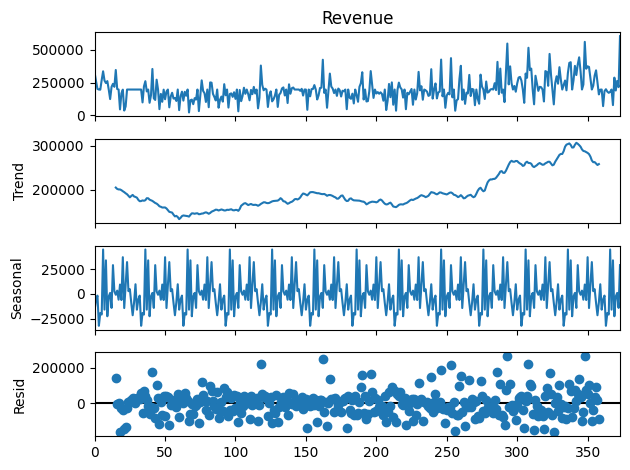

Seasonal pattern analysis:
0   -16000.269964
1    -5686.736370
2    -1769.876829
3   -32311.698213
4   -19405.785387
Name: seasonal, dtype: float64


In [38]:
#(using monthly)
period = 30

#decomposing the time series with an additive model
decomposed = seasonal_decompose(df_date_int['Revenue'], model='additive', period=period)

#plotting the decomposed components (trend, seasonal, residual)
decomposition_plot = decomposed.plot()
plt.show()


# Print some of the seasonal component for analysis
print("Seasonal pattern analysis:")
print(decomposed.seasonal.head())

Revenue Plot:

This plot is displaying the observed revenue data over time. This  pattern indicates fluctuations in revenue, with some noticeable spikes at different intervals, which shows that there are some high-revenue days in the monthly cycle.

Trend plot:

The trend plot is displaying the trend component of the time series. with this output it shows the overall trend seems to be increasing slightly, with a gradual rise and then a decline towards the end period. This indicates the general direction of revenue over time.

seasonal plot:

The is showing the seasonality of the revenue data. This is showing the repeated patterns at regular intervals, indicating that revenue tends to fluctuate in a predictable manner over time.

Residual (Noise):

This plot represents the residuals or random noise after the trend and seasonal components have been removed. The residual points are scattered around zero, indicating random fluctuations. This indicates that after getting the trend and seasonality, there is still some unexplained variance in the revenue data.

For my solution, I decided to add the missing dates by using the average revenue for the whole dataset. This is because using an average keeps the data balanced without making any assumptions about the missing days. I then used the seasonal_decompose function to break down the revenue data into three parts. trend (overall direction), seasonality (repeating patterns), and noise (random fluctuations). This helps us to see if there are any repeating patterns in the revenue.

Instead of using the average revenue, we could fill the missing dates by estimating or guessing their values through methods like interpolation (filling in the gaps based on nearby data). But using the average is simpler and less risky in terms of making wrong assumptions.

In terms of optimality, yes this solution is optimal because it keeps the time series clean and accurate. By adding only the missing dates and filling them with a neutral, average value, we can better analyze trends and patterns without introducing potential errors.

2.2.2

In [40]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")



# Setting the date as index
df_date_int.set_index('transaction_date', inplace=True)

# Splitting data into training (Jan 01, 2019 to Nov 01, 2019) and test sets
train = df_date_int['2019-01-01':'2019-11-01']
test = df_date_int['2019-11-02':]

# Defining p, d, q values for ARIMA
p = d = q = range(0, 3)

# getting all different combinations of p, d and q
pdq_combinations = [(x, y, z) for x in p for y in d for z in q]

# Storring results
best_pdq = None
lowest_mae = np.inf

# Grid search for the best ARIMA model
for pdq in pdq_combinations:
    try:
        # Fitting the ARIMA model
        model = ARIMA(train['Revenue'], order=pdq)
        model_fit = model.fit()

        # predictions making
        forecast = model_fit.forecast(steps=len(test))

        # Calculatting the MAE
        mae = mean_absolute_error(test['Revenue'], forecast)

        print(f"ARIMA{pdq} MAE: {mae}")

        # Keep track of the best model
        if mae < lowest_mae:
            lowest_mae = mae
            best_pdq = pdq

    except Exception as e:
        print(f"Error fitting ARIMA{pdq}: {e}")
        continue

# Print the best pdq combination
print(f"The best ARIMA model is ARIMA{best_pdq} with MAE = {lowest_mae}")


ARIMA(0, 0, 0) MAE: 105061.84796160487
ARIMA(0, 0, 1) MAE: 105072.43439964986
ARIMA(0, 0, 2) MAE: 104793.4738672585
ARIMA(0, 1, 0) MAE: 102024.62253289473
ARIMA(0, 1, 1) MAE: 91343.82908394517
ARIMA(0, 1, 2) MAE: 91327.41685577447
ARIMA(0, 2, 0) MAE: 1542063.0777138157
ARIMA(0, 2, 1) MAE: 100144.84446565389
ARIMA(0, 2, 2) MAE: 96633.76757725791
ARIMA(1, 0, 0) MAE: 105038.93541782438
ARIMA(1, 0, 1) MAE: 90168.7464027631
ARIMA(1, 0, 2) MAE: 104713.72421907156
ARIMA(1, 1, 0) MAE: 94205.82472578362
ARIMA(1, 1, 1) MAE: 91324.40056464184
ARIMA(1, 1, 2) MAE: 91300.47638426756
ARIMA(1, 2, 0) MAE: 654831.6055598474
ARIMA(1, 2, 1) MAE: 95676.0458929907
ARIMA(1, 2, 2) MAE: 95973.57561124509
ARIMA(2, 0, 0) MAE: 104554.68177972529
ARIMA(2, 0, 1) MAE: 104594.20419588627
ARIMA(2, 0, 2) MAE: 105205.40814388588
ARIMA(2, 1, 0) MAE: 93566.44299135324
ARIMA(2, 1, 1) MAE: 91366.04061733409
ARIMA(2, 1, 2) MAE: 91378.00307799985
ARIMA(2, 2, 0) MAE: 248451.21992251204
ARIMA(2, 2, 1) MAE: 95114.12327366353
ARI

Why this solution was chosen:

Used this ARIMA aproach because of its efficiency in time series forecasting. I used it here because it helps in , differencing, and moving average terms to model patterns in the data.

Grid search wass also used in other to search over for good combinations of (p, d, q) values to find the model with the lowest Mean Absolute Error (MAE), which indicates the best fit for predicting future values.

MAE: This metric was used in other to evaluate the prediction performance since it's straightforward and interprets the average magnitude of the errors.


Other models approach that can be use instead of Arima is  SARIMA (Seasonal ARIMA) expecially in a situation whereby seasonality plays a significant role.

In terms of optimalty,yes,the solution is optimal because the grid search was used to ensure that all reasonable parameter combinations were picked and select the model with the lowest MAE. this actually balances simplicity and effectiveness together.

### 2.3

LSTM Autoencoder for Time Series Forecasting
------------------------------------
- Data Pre-Processing
This sub-section describes the multiple data preprocessing techniques used to set a strong
basis for implementing complex deep learning architectures

- Normalization: Normalization is a technique designed to scale the input and output sequences of
the model, to assist in better training and convergence of deep learning models.

- Train-Test Split for Cross-Validation: Split the time series into training and test datasets.

- Modeling Steps:
Define LSTM Autoencoder: Create an encoder-decoder architecture using LSTM layers to capture temporal dependencies.

- Compile Model:
Use mean_squared_error loss function and Adam optimizer.

- Training: Train the autoencoder to predict the next time steps.

- Evaluating(Mean Absolute Error)
The mean absolute error metric performs the summation of error 𝑒𝑖, in its absolute value.
This results in the negative and positive differences canceling each other out and then
averaging them across all data points


Convolutional Neural Networks (CNNs)
-------------------------------------
- Data Pre-Processing
This sub-section describes the multiple data preprocessing techniques used to set a strong
basis for implementing complex deep learning architectures

- Normalization: Normalization is a technique designed to scale the input and output sequences of
the model, to assist in better training and convergence of deep learning models.

- Sliding Window Creation: Create fixed-size sliding windows for input and output.

- Train-Test Split for Cross-Validation: Split the time series into training and test datasets.

- Modeling Steps:
Define LSTM Autoencoder: Create an encoder-decoder architecture using LSTM layers to capture temporal dependencies.

- Compile Model: Use mean_squared_error loss function and Adam optimizer.

- Training: Train the autoencoder to predict the next time steps.

- Evaluating(Mean Absolute Error)
The mean absolute error metric performs the summation of error 𝑒𝑖, in its absolute value.
This results in the negative and positive differences canceling each other out and then
averaging them across all data points


 Recurrent Neural Networks (RNNs)
 ------------------------------------

 - Data Pre-Processing
This sub-section describes the multiple data preprocessing techniques used to set a strong
basis for implementing complex deep learning architectures

- Train-Test Split for Cross-Validation

- Modeling Steps:
Define LSTM Autoencoder: Create an encoder-decoder architecture using LSTM layers to capture temporal dependencies.

- Compile Model:
Use mean_squared_error loss function and Adam optimizer.

- Training: Train the autoencoder to predict the next time steps.

- Evaluating(Mean Absolute Error)
The mean absolute error metric performs the summation of error 𝑒𝑖, in its absolute value.
This results in the negative and positive differences canceling each other out and then
averaging them across all data points


Temporal Convolutional Network(TCN)
-------------------------------

- Data Pre-Processing
This sub-section describes the multiple data preprocessing techniques used to set a strong
basis for implementing complex deep learning architectures

- Train-Test Split for Cross-Validation

- Modeling Steps:
Define LSTM Autoencoder: Create an encoder-decoder architecture using LSTM layers to capture temporal dependencies.

- Compile Model:
Use mean_squared_error loss function and Adam optimizer.

- Training: Train the autoencoder to predict the next time steps.

- Evaluating(Mean Absolute Error)
The mean absolute error metric performs the summation of error 𝑒𝑖, in its absolute value.
This results in the negative and positive differences canceling each other out and then
averaging them across all data points

references
--------------------------

https://etda.libraries.psu.edu/catalog/23885rsr5259

https://etda.libraries.psu.edu/files/final_submissions/24573

[2] Bosari, J. (2012, October 4). Real Costs of Choosing the Wrong Software Vendor.
Forbes. https://www.forbes.com/sites/moneywisewomen/2012/10/04/real-costs-ofchoosing-the-wrong-software-vendor/?sh=4c29414b4997.
[3] Schmidhuber, J. (2015). Deep learning in neural networks: An overview. Neural
networks, 61, 85-117.

[4] Ullah, M. I. (2020, August 23). Components of Time Series. Basic Statistics and Data
Analysis. https://itfeature.com/time-series-analysis-and-forecasting/components-of-timeseries.

[5] Zhang, G. P. (2003). Time series forecasting using a hybrid ARIMA and neural
network model. Neurocomputing, 50, 159-175.

[6] Rahman, M. M., Islam, M. M., Murase, K., & Yao, X. (2015). Layered ensemble
architecture for time series forecasting. IEEE transactions on cybernetics, 46(1), 270-283.

[7] Sfetsos, A., & Coonick, A. H. (2000). Univariate and multivariate forecasting of hourly
solar radiation with artificial intelligence techniques. Solar Energy, 68(2), 169-178.

[8] Chandra, R., & Zhang, M. (2012). Cooperative coevolution of Elman recurrent neural
networks for chaotic time series prediction. Neurocomputing, 86, 116-123.

[9] Pan, C., Tan, J., Feng, D., & Li, Y. (2019, December). Very short-term solar generation
forecasting based on LSTM with temporal attention mechanism. In 2019 IEEE 5th

International Conference on Computer and Communications (ICCC) (pp. 267-271).
IEEE.